Demo notebook for inverse problems
==================================

**Table of content**
1. [Defining an inverse problem](#defining-an-inverse-problem)
1. [Example on CelebaHQ dataset with DPS algorithm](#example-on-celebahq-dataset-with-dps-algorithm)
1. [Example on FFHQ dataset with $\Pi\text{GDM}$ algorithm](#example-on-ffhq-dataset-with--algorithm)


# Defining an inverse problem

Inverse problem,
\begin{equation*}
    y = A x + \sigma \ \epsilon
\end{equation*}
- $y$ the observation
- $A$ the degradation operator
- $\sigma \ \epsilon$ Gaussian noise $\mathcal{N}(0, \sigma I)$

Let's see how to

1. Load an image
1. Load the degradation operator $A$
1. Plot the observation $y$


## Loading an image

In [1]:
from functools import partial
import os
import argparse
import yaml

import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from dmps.guided_diffusion.condition_methods import get_conditioning_method
from dmps.guided_diffusion.measurements import get_noise, get_operator
from dmps.guided_diffusion.unet import create_model
from dmps.guided_diffusion.gaussian_diffusion import create_sampler
from dmps.data.dataloader import get_dataset, get_dataloader
from dmps.util.img_utils import clip, clear_color,clear, mask_generator, center_crop
from dmps.util.logger import get_logger
from dmps.util.data_preprocessing import CenterCropLongEdge

def load_yaml(file_path: str) -> dict:
    with open(file_path) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    return config

import numpy as np
from skimage.metrics import peak_signal_noise_ratio
import random
import os
import time


/home/obanmarcos/PhD/Projects/GM Hackathon/hackathon_starter_kit/venv-hackathon/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
args = {}
args['model_config'] = './dmps/configs/model_config.yaml'
args['diffusion_config'] = './dmps/configs/diffusion_config.yaml'
args['task_config'] = './dmps/configs/sr4_config.yaml'
args['gpu'] = 0
args['save_dir'] = './saved_results'
args['seed'] = 0

logger = get_logger()
    
# Device setting
device_str = f"cuda:{args['gpu']}" if torch.cuda.is_available() else 'cpu'
logger.info(f"Device set to {device_str}.")
device = torch.device(device_str)  

# Load configurations
model_config = load_yaml(args["model_config"])
diffusion_config = load_yaml(args["diffusion_config"])
task_config = load_yaml(args["task_config"])


# Load model
model = create_model(**model_config)

if model_config['use_fp16']:
    model.convert_to_fp16()
model = model.to(device)
model.eval()

# Prepare Operator and noise
measure_config = task_config['measurement']
operator = get_operator(device=device, **measure_config['operator'])
noiser = get_noise(**measure_config['noise'])
logger.info(f"Operation: {measure_config['operator']['name']} / Noise: {measure_config['noise']['name']}")

# Prepare conditioning method
cond_config = task_config['conditioning']
cond_method = get_conditioning_method(cond_config['method'], operator, noiser, **cond_config['params'])
measurement_cond_fn = cond_method.conditioning
logger.info(f"Conditioning method : {task_config['conditioning']['method']}")

# Load diffusion sampler
sampler = create_sampler(**diffusion_config) 
sample_fn = partial(sampler.p_sample_loop, model=model, measurement_cond_fn=measurement_cond_fn)

# Working directory
out_path = os.path.join(args["save_dir"], measure_config['operator']['name'])
out_path = os.path.join(args["save_dir"], measure_config['operator']['name'], 'seed_{}'.format(args["seed"]))
os.makedirs(out_path, exist_ok=True)
for img_dir in ['input', 'recon', 'progress', 'truth']:
    os.makedirs(os.path.join(out_path, img_dir), exist_ok=True)


2024-07-09 23:14:35,715 [DPS] >> Device set to cuda:0.
2024-07-09 23:14:35,715 [DPS] >> Device set to cuda:0.
2024-07-09 23:14:37,501 [DPS] >> Operation: super_resolution / Noise: gaussian
2024-07-09 23:14:37,501 [DPS] >> Operation: super_resolution / Noise: gaussian
2024-07-09 23:14:37,503 [DPS] >> Conditioning method : dmps
2024-07-09 23:14:37,503 [DPS] >> Conditioning method : dmps


NameError: Name dps is not defined!

In [3]:
# Prepare dataloader
data_config = task_config['data']
if data_config['name'] == 'imagenet' or data_config['name'] == 'cat':
    transform = transforms.Compose([
        CenterCropLongEdge(),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
else:
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


dataset = get_dataset(**data_config, transforms=transform)
loader = get_dataloader(dataset, batch_size=1, num_workers=0, train=False)

## Operator set-up

In [4]:
H_funcs = None
if measure_config['operator']['name'] == 'super_resolution':
    if measure_config['operator']['type'] == 'standard':
        ratio = measure_config['operator']['scale_factor']
        from dmps.util.functions import SuperResolution
        H_funcs = SuperResolution(3, 256, ratio, device)
    elif measure_config['operator']['type'] == 'bicubic':
        factor = measure_config['operator']['scale_factor']
        ratio = factor
        print('ratio: {}'.format(ratio))
        from dmps.util.functions import SRConv
        def bicubic_kernel(x, a=-0.5):
            if abs(x) <= 1:
                return (a + 2)*abs(x)**3 - (a + 3)*abs(x)**2 + 1
            elif 1 < abs(x) and abs(x) < 2:
                return a*abs(x)**3 - 5*a*abs(x)**2 + 8*a*abs(x) - 4*a
            else:
                return 0
        k = np.zeros((factor * 4))
        for i in range(factor * 4):
            x = (1/factor)*(i- np.floor(factor*4/2) + 0.5)
            k[i] = bicubic_kernel(x)
        k = k / np.sum(k)
        kernel = torch.from_numpy(k).float().to(device)
        H_funcs = SRConv(kernel / kernel.sum(),model.in_channels, model.image_size, device, stride = factor)
    else:
        print("ERROR: super_resolution type not supported")
        quit()

elif measure_config['operator']['name'] == 'deblur':
    if measure_config['operator']['type'] == 'gaussian':
        from dmps.util.functions import Deblurring
        sigma = measure_config['operator']['intensity']
        pdf = lambda x: torch.exp(torch.Tensor([-0.5 * (x / sigma) ** 2]))
        size = (measure_config['operator']['kernel_size']+1)//2
        temp_value = torch.linspace(-(size-1)/2, (size-1)/2, steps=size)
        gauss_pdf = torch.zeros(len(temp_value))
        for id in range(len(temp_value)):
            gauss_pdf[id] = pdf(temp_value[id])
        kernel = gauss_pdf.to(device)
        # kernel = torch.Tensor([pdf(-2), pdf(-1), pdf(0), pdf(1), pdf(2)]).to(device)
        H_funcs = Deblurring(kernel / kernel.sum(), model.in_channels, model.image_size, device)
        ratio = 1
    elif measure_config['operator']['type'] == 'uniform':
        from dmps.util.functions import Deblurring
        H_funcs = Deblurring(torch.Tensor([1/9] * 9).to(device), model.in_channels, model.image_size, device)

    elif measure_config['operator']['type'] == 'aniso':
        from dmps.util.functions import Deblurring2D
        sigma = measure_config['operator']['intensity']
        pdf = lambda x: torch.exp(torch.Tensor([-0.5 * (x/sigma)**2]))
        kernel2 = torch.Tensor([pdf(-4), pdf(-3), pdf(-2), pdf(-1), pdf(0), pdf(1), pdf(2), pdf(3), pdf(4)]).to(device)
        sigma = measure_config['operator']['intensity']
        pdf = lambda x: torch.exp(torch.Tensor([-0.5 * (x/sigma)**2]))
        kernel1 = torch.Tensor([pdf(-4), pdf(-3), pdf(-2), pdf(-1), pdf(0), pdf(1), pdf(2), pdf(3), pdf(4)]).to(device)
        H_funcs = Deblurring2D(kernel1 / kernel1.sum(), kernel2 / kernel2.sum(), model.in_channels, model.image_size, device)
    else:
        print("ERROR: deblur type not supported")
        quit()
    ratio = 1
elif measure_config['operator']['name']  == 'color':
    from dmps.util.functions import Colorization
    H_funcs = Colorization(model.image_size, device)
    ratio = 1
elif measure_config['operator']['name'] == 'denoise':
    from dmps.util.functions import Denoising
    H_funcs = Denoising(model.in_channels, model.image_size, device)
    ratio = 1
else:
    print("ERROR: The task type not supported")
    quit()

ratio: 4


## Inference.

In [5]:
start_time  = time.time()
Num_count = 0
psnr_results = []
gamma = 1e-2
for i, ref_img in enumerate(loader):
    
    if i == 1: 
        break

    logger.info(f"Inference for image {i}")
    fname = str(i).zfill(5) + '.png'
    ref_img = ref_img.to(device)
    Num_count += 1

    y_x = H_funcs.H(ref_img) # forward linear measurements

    y_n = y_x + noiser.sigma * torch.randn_like(y_x)
    
    # General-Purpose Posterior Sampling via DMPS and output the results
    DMPS_start_time = time.time()
    x_start = torch.randn(ref_img.shape, device=device).requires_grad_()
    sample = sample_fn(x_start=x_start, measurement=y_n, H_funcs=H_funcs, noise_std = noiser.sigma, record=True, save_root=out_path)
    DMPS_end_time = time.time()
    print('DMPS running time: {}'.format(DMPS_end_time - DMPS_start_time))
    psnr = peak_signal_noise_ratio(ref_img.cpu().numpy(),sample.cpu().numpy())
    psnr_results.append([psnr])
    print('PSNR: {}'.format(psnr))

    if measure_config['operator']['name']  == 'color':
        y_n = y_n.reshape(1,1,model.image_size,model.image_size)
        plt.imsave(os.path.join(out_path, 'input', fname), clear(y_n),cmap='gray')
    else:
        input_size = int(model.image_size/ratio)  
        y_n = y_n.reshape(1,model.in_channels,input_size,input_size)
        plt.imsave(os.path.join(out_path, 'input', fname), clear_color(y_n))
    plt.imsave(os.path.join(out_path, 'truth', fname), clear_color(ref_img))
    plt.imsave(os.path.join(out_path, 'recon', fname), clear_color(sample))

end_time = time.time()
running_time = end_time - start_time
save_results = np.zeros(3)
save_results[0] = measure_config['noise']['sigma']
save_results[1] = running_time
save_results[2] = Num_count
np.savetxt(os.path.join(out_path, 'saved_results.csv'),save_results)


np.savetxt(os.path.join(out_path, 'psnr_results.csv'),np.array(psnr_results))
print('Total # imges:{}, total  running Time: {}'.format(Num_count,end_time - start_time))


2024-07-09 21:55:45,984 [DPS] >> Inference for image 0
100%|██████████| 1000/1000 [02:06<00:00,  7.92it/s]


DMPS running time: 126.28430581092834
PSNR: 29.00055897347039
Total # imges:1, total  running Time: 126.40192532539368


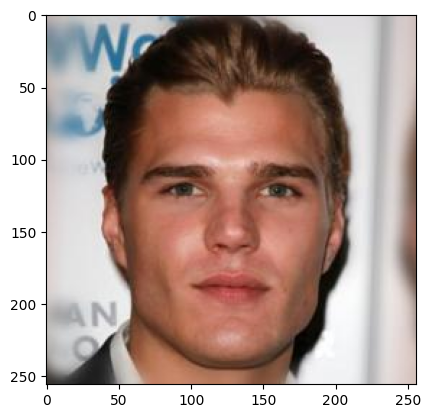

In [3]:
from utils import load_image, display_image
import matplotlib.pyplot as plt

# load the image
img_path = "./material/celebahq_img/00010.jpg"
x_origin = load_image(img_path)

# plot the image
fig, ax = plt.subplots()

display_image(x_origin, ax)


## Loading the degradation operator

Let's load SR16 degradation operator

It reduces the resolution of the image by $16$

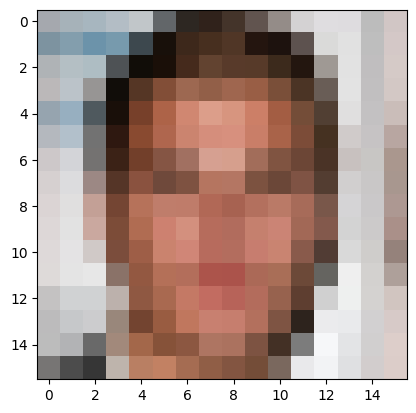

In [4]:
import math
import torch

# load the degradation operator
path_operator = f"./material/degradation_operators/sr16.pt"
degradation_operator = torch.load(path_operator, map_location="cpu")

# apply degradation operator
# NOTE: it operates on bach of images
y = degradation_operator.H(x_origin[None])

# reshape to plot the observation
# NOTE: y is a square image with 3 channels
n_channels = 3
n_pixel_per_channel = y.shape[1] // n_channels
hight = width = int(math.sqrt(n_pixel_per_channel))

y_reshaped = y.reshape(n_channels, hight, width)

# plot the image
fig, ax = plt.subplots()
display_image(y_reshaped)

Let's add Gaussian noise with $\sigma = 0.1$

In [ ]:
# add noise
sigma = 0.1
y_reshaped_noised = y_reshaped + sigma * torch.randn_like(y_reshaped)

# plot the three images side by side
fig, axes = plt.subplots(1, 3)

images = (x_origin, y_reshaped, y_reshaped_noised)
titles = ("original", "degraded", "degraded + noise")

for ax, img, title in zip(axes, images,titles):
    display_image(img, ax)
    ax.set_title(title)

fig.tight_layout()

In the end, the inverse problem can be defined using the tuple ``(y, degradation_operator, sigma)``

**Note**:
In practice, we don't have access to $x$ (in the code ``x_origin``) but only to $y$, $A$, and $\sigma$

# Example on CelebaHQ dataset with DPS algorithm

The model details and checkpoint can be found in [Hugging Face](https://huggingface.co/google/ddpm-celebahq-256)

Here, the package ``Diffusers`` is used under the hood to load the model.

Beforehand, let's load the model and perform unconditional sampling

In [ ]:
import torch
from utils import load_epsilon_net
from sampling.unconditional import unconditional_sampling


# load the noise predictor with 1000 diffusion steps
device = "cuda:0"
n_steps = 1000
torch.set_default_device(device)

eps_net = load_epsilon_net("celebahq", n_steps, device)

# check unconditional generation
# NOTE: use initial noise to specify number of generated samples
initial_noise = torch.randn((1, 3, 256, 256), device=device)
generated_images = unconditional_sampling(eps_net, initial_noise, display_im=False)

# plot image
fig, ax = plt.subplots()
display_image(generated_images[0], ax)

Now we have all the building blocks to solve linear inverse problems.

Let's solve SR16 problem with CelebaHQ model prior using DPS algorithm [1].


.. [1] Chung, Hyungjin, et al. "Diffusion posterior sampling for general noisy inverse problems." arXiv preprint arXiv:2209.14687 (2022).


In [ ]:
device = "cuda:0"
torch.set_default_device(device)


# define first the inverse problem

# load the image
img_path = "./material/celebahq_img/00010.jpg"
x_origin = load_image(img_path, device)


# load the degradation operator
path_operator = f"./material/degradation_operators/sr16.pt"
degradation_operator = torch.load(path_operator, map_location=device)

# apply degradation operator
y = degradation_operator.H(x_origin[None])
y = y.squeeze(0)

# add noise
sigma = 0.01
y = y + sigma * torch.randn_like(y)

inverse_problem = (y, degradation_operator, sigma)

In [ ]:
from utils import load_epsilon_net
from sampling.dps import dps

# load model with 500 diffusion steps
n_steps = 500
eps_net = load_epsilon_net("celebahq", n_steps, device)

# solve problem
initial_noise = torch.randn((1, 3, 256, 256), device=device)
reconstruction = dps(initial_noise, inverse_problem, eps_net)

In [ ]:
# plot results

# reshape y
n_channels = 3
n_pixel_per_channel = y.shape[0] // n_channels
hight = width = int(math.sqrt(n_pixel_per_channel))

y_reshaped = y.reshape(n_channels, hight, width)

# init figure
fig, axes = plt.subplots(1, 3)

images = (x_origin, y_reshaped, reconstruction[0])
titles = ("original", "degraded", "reconstruction")

# display figures
for ax, img, title in zip(axes, images,titles):
    display_image(img, ax)
    ax.set_title(title)

fig.tight_layout()

# Example on FFHQ dataset with $\Pi\text{GDM}$ algorithm

The model details can be found in [Diffusion Posterior Sampling for General Noisy Inverse Problems](https://arxiv.org/abs/2209.14687) in the Experiment section.

The model checkpoint, ``ffhq_10m.pt``, can be downloaded [here](https://drive.google.com/drive/folders/1jElnRoFv7b31fG0v6pTSQkelbSX3xGZh)

Beforehand, let's load the model and perform unconditional sampling

In [ ]:

# load the noise predictor with 500 diffusion steps
device = "cuda:0"
n_steps = 1000
torch.set_default_device(device)

eps_net = load_epsilon_net("ffhq", n_steps, device)

# check unconditional generation
# NOTE: use initial noise to specify number of generated samples
initial_noise = torch.randn((1, 3, 256, 256), device=device)
generated_images = unconditional_sampling(eps_net, initial_noise, display_im=False)

# plot image
fig, ax = plt.subplots()
display_image(generated_images[0], ax)

Now let's solve an inpainting problem with FFHQ prioir using $\Pi\text{GDM}$ algorithm [1]

.. [1] Song, Jiaming, et al. "Pseudoinverse-guided diffusion models for inverse problems." International Conference on Learning Representations. 2023.

In [ ]:
device = "cuda:0"
torch.set_default_device(device)


# define first the inverse problem

# load the image
img_path = "./material/ffhq_img/00018.png"
x_origin = load_image(img_path, device)

# load the degradation operator
path_operator = f"./material/degradation_operators/inpainting_middle.pt"
degradation_operator = torch.load(path_operator, map_location=device)

# apply degradation operator
y = degradation_operator.H(x_origin[None])
y = y.squeeze(0)

# add noise
sigma = 0.01
y = y + sigma * torch.randn_like(y)

inverse_problem = (y, degradation_operator, sigma)


This algorithm leverages the SVD decomposition of the degradation operator $A = U^\top \Sigma V$

Therefore, let's use ``EpsilonNetSVD`` to make the right transformations.

In [ ]:
from utils import load_epsilon_net
from sampling.pgdm import pgdm_svd
from sampling.epsilon_net import EpsilonNetSVD

# load model with 500 diffusion steps
n_steps = 500
eps_net = load_epsilon_net("ffhq", n_steps, device)

eps_net_svd = EpsilonNetSVD(
        net=eps_net.net,
        alphas_cumprod=eps_net.alphas_cumprod,
        timesteps=eps_net.timesteps,
        H_func=degradation_operator,
        device=device,
    )

# solve problem
initial_noise = torch.randn((1, 3, 256, 256), device=device)
reconstruction = pgdm_svd(initial_noise, inverse_problem, eps_net_svd)

In [ ]:
# plot results

# reshape y
y_reshaped =  -torch.ones(3 * 256 * 256, device=device)
y_reshaped[: y.shape[0]] = y
y_reshaped = degradation_operator.V(y_reshaped[None])
y_reshaped = y_reshaped.reshape(3, 256, 256)


# init figure
fig, axes = plt.subplots(1, 3)

images = (x_origin, y_reshaped, reconstruction[0])
titles = ("original", "degraded", "reconstruction")

# display figures
for ax, img, title in zip(axes, images,titles):
    display_image(img, ax)
    ax.set_title(title)

fig.tight_layout()